# Determining liquidity ranges using Reinforcement Learning (RL)

This experiment aims to train a RL agent to find optimal price ranges in which the future price of an asset will evolve. We can then use the output of the agent to provide liquidity on Concentrated Liquidity AMMs like Uniswap v3.
For a first experiment, we've simplified the problem to a single and simpe objective:

**Finding the smallest price range that has the longest *lifespan****  

\* *The lifespan of a liquidity range is defined as the amount of time the price spends in the range, as soon as the price exits the range, it is considered "dead"*

Although we don't directly account for costs associated with changing ranges and the exact fees accrued, our simplification captures most of these problematics:
* Incentivizing the agent to find the smallest possible price ranges will lead to higher fees collected as more of the capital provided as liquidity is utilized;
* Incentivizing the agent to find liquidity ranges with long lifespans will diminish the costs associated with changing ranges compared to fees collected

## Process
### Data input
We feed our agent with the ETH/BTC price history, in an attempt for it to predict ranges for liquidity providing on the UniV3 WBTC/WETH pair. We also provide additional technical analysis (TA) datapoints derived from the price:
* Trailing volatility metrics;
* Bollinger Bands.

The agent uses a portion of the recent price history and additional TA data to predict the optimal range. The amount of days of historical data consumed by the model is a hyperparameter of our environmnent: `lookback_periods`

### Step description
At each step, we use the model's prediction to set the new range:
* the first element of the prediction provides the distance of the range's lower bound to the current price;
* the second element of the prediction provides the distance of the range's higher bound to the current price.

We then calculate the range's lifespan or accrued fees, and eventual penalties e.g. if the model sets a wrong range (one of the bounds is lower than zero, the lower bound is equal to the higher bound). As soon as the price exits the range given by the model, we calculate the next range until we reach the end of our price data.

### Asymptotical cases
Some asymptotical cases the model might end up optimizing for are:
1. Setting a huge range from which the price never exits: the model could find this scenario to be optimal as it would incur a single step and no penalties. We counter this by setting a maximum range width as a hyperparameter of our environment: `max_range_width`. We also ensure that rewards are always proportional to the inverse of the range's width.
1. Setting tiny ranges that collect a maximum reward but are reset almost every period. We counter this by setting a minimum amount of periods under which the model accrues penalties: `min_lifespan_no_penalty`.

### Additional parameters
To help the model predict better the outcome of an action, we also cap the rewards. We give the model maximum reward as long as the liquidity range suggested reaches a minimum lifespan, this is tweakable as hyperparameters of our environment: `cap_rewards` and `target_range_min_lifespan`. We transform the model's reward function from "How much fees will this liquidity range provide in the future?" (ranging from 0 to inf) to "What's the probability this liquidity range lasts at least N periods?" (ranging from 0 to 1), which makes it easier to optimize for.

We also provide the capability to set the model's range setting to: 
* absolute: `liquidity bound = current price +/- model suggestion`
* relative: `liquidity lower bound = current price * (1 +/- model suggestion)`

Ultimately, the most realistic scenario in the `relative` one given how Uniswap V3's [tick system](https://docs.uniswap.org/concepts/protocol/concentrated-liquidity#ticks) works (1 tick = 0.01% price change)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import gymnasium as gym

df = pd.read_csv('ethbtc-daily.csv').sort_values('datetime').reset_index(drop=True)
df.head(5)

,datetime,close
0,2016-01-01,0.002141
1,2016-01-02,0.002145
2,2016-01-03,0.002254
3,2016-01-04,0.002192
4,2016-01-05,0.002198


<AxesSubplot: title={'center': 'UniV3 ETH/BTC Bollinger Bands ratios'}, xlabel='datetime'>

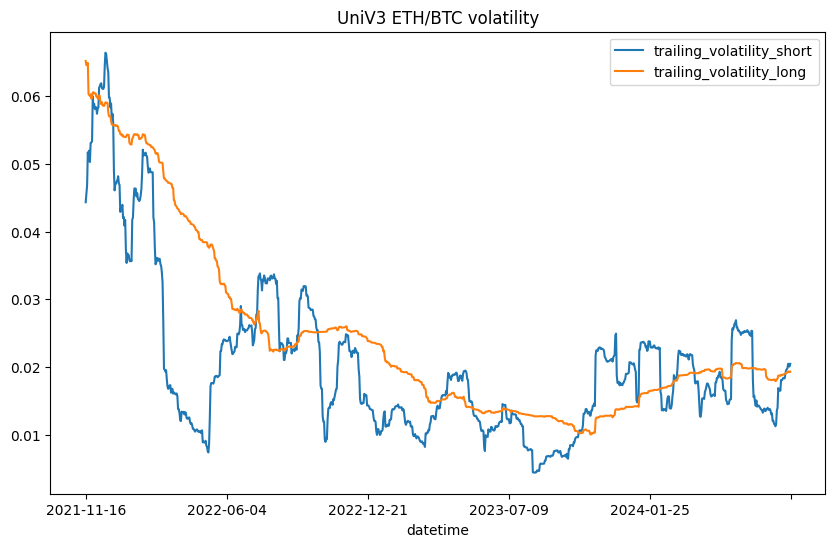

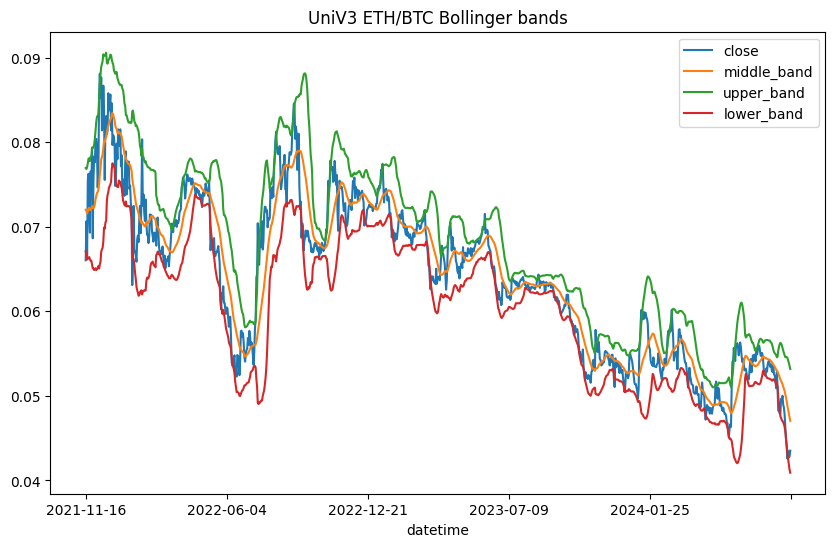

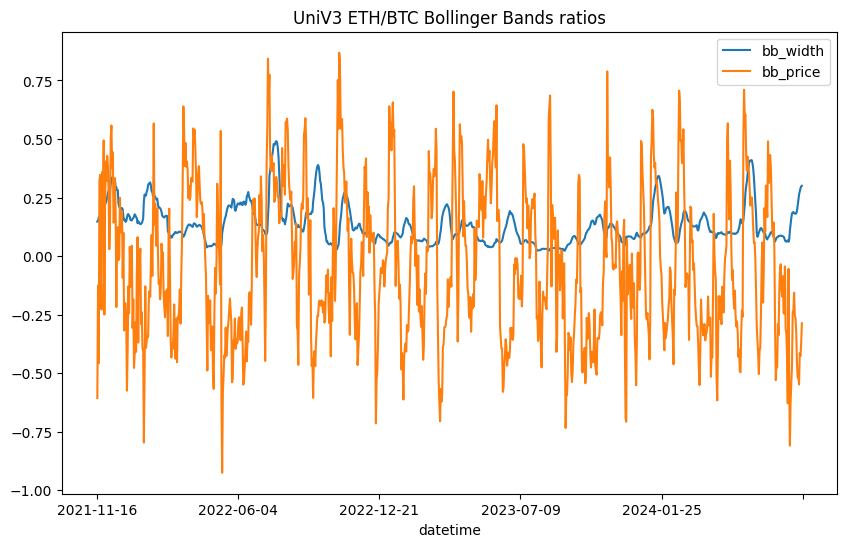

In [2]:
from data_processing.my_ta import bollinger_bands, volatility

df[['trailing_volatility_short', 'trailing_volatility_long']] = volatility(df)
df[['middle_band', 'upper_band', 'lower_band','bb_width','bb_price', 'bb_price_to_lower_band', 'bb_price_to_higher_band']] = bollinger_bands(df)

df.tail(1000).plot(x= 'datetime', y=['trailing_volatility_short', 'trailing_volatility_long'], figsize = (10,6), title="UniV3 ETH/BTC volatility")
df.tail(1000).plot(x= 'datetime', y=['close', 'middle_band', 'upper_band', 'lower_band'], figsize = (10,6), title="UniV3 ETH/BTC Bollinger bands")
df.tail(1000).plot(x= 'datetime', y=['bb_width', 'bb_price'], figsize = (10,6), title="UniV3 ETH/BTC Bollinger Bands ratios")

### Defining and scaling input features
**Important**: All price-related features (OHLC, moving averages, bollinger bands...) need to be scaled with the same scaling parameters. We avoid this issue by having all price-related features expressed as ratios to the current daily closing price.

In [3]:
from sklearn.preprocessing import MinMaxScaler

#drop price-related features
df.drop(['middle_band','upper_band','lower_band'], axis=1, inplace=True)

FEATURES = list(df.columns)
FEATURES.remove('datetime')
FEATURES

data = df[FEATURES].copy()
scaler = MinMaxScaler()

scaled_data = scaler.fit_transform(data)

df[['scaled_'+ f for f in FEATURES]] = scaled_data
df_train = pd.DataFrame(scaled_data, columns = FEATURES).dropna().reset_index(drop=True)

### Defining our environment 
We define our environment following the principles stated in the notebook intro.

In general, we apply the following penalties to ensure the algorithm learns correctly from the environment:
* `range_change`: unused - Applies a penalty whenever the algorithm changes range. We do not activily use this penalty as the algorithm is already incentivized to minimize range changes. However it is possible to associate a cost with range changing to get a more accurate reward function.
* `range_error`: penalties to teach the models which range parameters are out of bounds to prevent things like setting the lower bound higher than the upper bound (and vice versa), any of the bounds lower than 0 or higher than 1...
* `range_too_wide`: unused - Applies a penalty whenever the algorithm applies a range that is too wide. We changed this by limiting the range width that the algo can apply, it makes learning easier.
* `price_out_of_range`: penalty to be applied when the price exits the range, it is currently applied when the price doesn't spend enough time in range. It is slightly redundant with `range_change` but we do not use it in the same cases.

In [4]:
from gymnasium import spaces
from environment.utils import LiquidityRange

class UniswapV3Env(gym.Env):
    def __init__(
        self, 
        price_data, 
        lookback_periods=30,
        range_setting_relative=True, #False for absolute range setting
        max_range_width=.15,
        cap_rewards=False,
        target_range_min_lifespan=30,
        min_lifespan_no_penalty=5,
        penalties={'range_change': 1, 'range_error': 1, 'range_too_wide': .001, 'price_out_of_range': 2},
    ):
        """Creates a Uniswap V3 environment to train a RL agent
        
        Parameters
        ----------
        price_data : pandas dataframe 
            The price history to train the agent, the dataframe should have at least 2 columns: 'datetime', 'close'. Any other column will
            be integrated as input features. Including additional TA (moving average, RSI...) or price (high, low, volume) is possible. 
        lookback_periods : int 
            The number of periods that the agent can analyze
        range_setting_relative: bool
            The method to set the range around current price. If set to `True`, the liquidity range is set by multiplying the agent's output
            to the current price, effectively setting a range in % values around the current price. If set to `False` the liquidity range is 
            set by adding/subtracting the agent's output from the current price. 
        max_range_width : float
            The maximum width of the range that the agent is allowed to set, normalized between 0 and 1. If `range_setting_relative=True`,
            this represents the maximum percent values around the current price.
        cap_rewards: bool
            Defines the definition of the reward function. If set to `True`, the agent receives the maximum reward as long as the set range
            has a lifespan higher than `target_range_min_lifespan`. If set to `False`, the agent receives a reward proportionate to the time
            spent in range.
        target_range_min_lifespan: int
            If `cap_rewards=True`, defines the minimum number of periods that the price should spend in-range for the agent to receive the 
            reward.
        min_lifespan_no_penalty: int
            If `cap_rewards=True`, defines the minimum number of periods that the price should spend in-range to avoid receiving an out of
            range penalty. This incentivizes the agent to avoid looking for a local extrema while accumulating 0 rewards.
        penalties: dict
            Defines a list of penalty types and their associated value.
        """
        super(UniswapV3Env, self).__init__()
        
        #Set attributes
        self.price_data = price_data
        self.max_range_width = max_range_width
        self.lookback_periods = lookback_periods
        self.feature_names = price_data.columns
        self.range_setting_relative = range_setting_relative
        self.target_range_min_lifespan = target_range_min_lifespan
        self.cap_rewards = cap_rewards
        self.min_lifespan_no_penalty = min_lifespan_no_penalty
        self.PENALTIES = penalties
        self.training = False
        #Decfine the agent's action space 
        # *index 0: lower bound delta (% or absolute) below current price
        # *index 1: upper bound delta (% or absolute) above current price
        self.action_space = spaces.Box(
            low=0.02, high=1, shape=(2,), dtype=np.float32
        )
        
        self.observation_space = spaces.Box(low=0, high=1, shape=(self.lookback_periods, self.price_data.shape[1]), dtype=np.float32)
        
        self.init()
    
    def _train(self):
        self.training = True
    
    def _eval(self):
        self.training = False
        
    def init(self):
        self.current_step = self.lookback_periods
        self.liquidity_range = LiquidityRange(
            self._get_current_price() * .95, 
            self._get_current_price() * 1.05
        )
        self.range_changes = 0
        self.penalty = 0
        
    def reset(self, **kwargs):
        self.init()
        return self._get_observation(), {}

    def step(self, action):
        self.penalty=0
        
        lower_bound_delta_from_price, upper_bound_delta_from_price = action[0], action[1]
        current_price = self._get_current_price()
        
        if self.range_setting_relative:
            new_lower_bound = current_price * (1 - lower_bound_delta_from_price * self.max_range_width/2)
            new_upper_bound = current_price * (1 + upper_bound_delta_from_price * self.max_range_width/2)
        else:
            new_lower_bound = current_price - lower_bound_delta_from_price * self.max_range_width/2
            new_upper_bound = current_price + upper_bound_delta_from_price * self.max_range_width/2
        
        self._update_range(new_lower_bound, new_upper_bound)
        self._check_range()
        
        # Calculate the total reward accrued and the step ID until price exits the current range
        total_reward, next_step = self._calculate_reward()
        
        reward = total_reward + self.penalty
        
        #we add a randomized definition of the next step between current_step and next_step to ensure optimal exploration
        current_step = self.current_step
        if self.training and next_step < len(self.price_data) - 1:
            #In training mode, we always randomize the step of the next decision
            self.current_step += int((next_step - current_step) * np.random.uniform())+1
        else:
            #unless we arrived at the end of the price data, or we're in eval mode
            self.current_step = next_step
            
        terminated = self.current_step >= len(self.price_data) - 1
        truncated=False
        
        return self._get_observation(), reward, terminated, truncated, {}
    
    def _calculate_reward(self):
        #from price history, find the first step for which the price exits the range
        next_step = int(np.nan_to_num(
            self.price_data[self.current_step:].loc[
                (self.price_data.close > self.liquidity_range.upper_bound) | (self.price_data.close < self.liquidity_range.lower_bound) 
            ].index.min(), 
            #if this returns nan, it means the price is in range until the end of the timeseries
            nan=self.price_data.index.max()
        ))
        
        #calculate fees accrued from current_step to next_step
        total_rewards = self._calculate_rewards_between_steps(self.current_step, next_step)
        
        return total_rewards, next_step
    
    def _calculate_rewards_between_steps(self, step_from, step_to):
        if step_to < step_from:
            step_from_buffer = step_from
            step_from = step_to
            step_to = step_from_buffer
        
        #count all data points between the steps where the closing price is in range, and divide by range width
        price_points_in_range = len(self.price_data[step_from:step_to+1].loc[
            (self.price_data.close <= self.liquidity_range.upper_bound) & (self.price_data.close >= self.liquidity_range.lower_bound)
        ])
        
        range_width = self.liquidity_range.width()
        
        if self.cap_rewards and price_points_in_range >= self.target_range_min_lifespan:
            #if the agent succeeds in setting a range with high enough lifespan, then give it the max reward divided by the range width
            #This incentives setting smaller ranges
            max_range_width = self._get_absolute_max_range_width()
            return 1 - 0.9*(range_width/max_range_width)**2
        
        elif self.cap_rewards and step_to >= len(self.price_data) - 1:
            #we reached the end of the price data, in this case we assume a successful range
            max_range_width = self._get_absolute_max_range_width()
            return 1 - 0.9*(range_width/max_range_width)**2
        
        elif self.cap_rewards and price_points_in_range < self.min_lifespan_no_penalty:
            #if the agent sets a range with a lifespan below the minimum threshold for no penalty, it receives a penalty 
            self.penalty -= self.PENALTIES['price_out_of_range']
            return 0
        
        elif not self.cap_rewards and range_width > 0:
            return np.sqrt(price_points_in_range / range_width)
        
        else:
            #return 0 rewards if 
            #1. the range width is <=0 (=range error) 
            #2. The lifespan of the liquidity range is between min_lifespan_no_penalty and target_range_min_lifespan
            return 0

    def _check_range(self):
        range_width = self.liquidity_range.width()
        max_range_width = self._get_absolute_max_range_width()
        
        if range_width > max_range_width:
            self.penalty -= self.PENALTIES['range_too_wide']*range_width
        if range_width <= 0:
            self.penalty -= self.PENALTIES['range_error']
            self.penalty -= self.PENALTIES['price_out_of_range']
        
    def _get_observation(self):
        if self.current_step < self.lookback_periods:
            # Pad with zeros if we’re at the beginning and don’t have N steps yet
            history = np.zeros((self.lookback_periods, self.price_data.shape[1]))
            history[:, -self.current_step:] = self.price_data.iloc[:self.current_step][self.feature_names].values
        else:
            # Collect the last N steps of data
            history = self.price_data.iloc[self.current_step - self.lookback_periods:self.current_step][self.feature_names].values
        
        current_price = self._get_current_price()
        
        return history
    
    def _get_current_price(self):
        return self.price_data.loc[self.current_step, 'close']

    def _calculate_out_of_range_penalty(self):
        current_price = self.price_data.iloc[self.current_step]['close']
        if current_price < self.liquidity_range.lower_bound or current_price > self.liquidity_range.upper_bound:
            return -np.log(2)  # Penalty for being out of range
        return 0
    
    
    def _update_range(self, new_lower_bound, new_upper_bound):
        self.range_changes += 1
        
        #add penalty for changing range = blockchain costs + realized impermanent loss incurred from range change (estimated)
        #self.penalty -= self.PENALTIES['range_change']
        
        #add penalties for setting range bounds that are too low or too high
        if new_lower_bound != np.clip(new_lower_bound,0,1):
            self.penalty -= self.PENALTIES['range_error']
            new_lower_bound = np.clip(new_lower_bound,0,1)
        if new_upper_bound != np.clip(new_upper_bound,0,1):
            self.penalty -= self.PENALTIES['range_error']
            new_upper_bound = np.clip(new_upper_bound,0,1)
        
        if new_upper_bound <= new_lower_bound:
            #add penalty for lower bound higher than upper bound
            self.penalty -= self.PENALTIES['range_error']
            self.liquidity_range = LiquidityRange(lower_bound=new_upper_bound, upper_bound=new_lower_bound)
        else:
            self.liquidity_range = LiquidityRange(lower_bound=new_lower_bound, upper_bound=new_upper_bound)
            
    def _get_absolute_max_range_width(self):
        if self.range_setting_relative:
            return self._get_current_price()*(1+self.max_range_width/2) - self._get_current_price()*(1-self.max_range_width/2)
        else:
            return self.max_range_width

### Model Training

We train the model on a given set of environment hyperparameters. We also use an entropy callback controller to add decaying entropy to our training to improve agent's exploration.

In [5]:
from stable_baselines3 import PPO, DQN, DDPG
from model.entropy_decay import EntropyDecayCallback
from stable_baselines3.common.noise import NormalActionNoise, OrnsteinUhlenbeckActionNoise

#Define the number of training steps
total_timesteps=2**14

callback = EntropyDecayCallback(initial_entropy_coef=0.1, final_entropy_coef=0.01, total_timesteps=total_timesteps)

#env hyperparams
LOOKBACK_PERIODS = 360
MAX_RANGE_WIDTH = .2
TARGET_RANGE_MIN_LIFESPAN = 10 #objective of N days in range
MIN_LIFESPAN_NO_PENALTY=10 #Price should spend a minimum of N days in range for the agent not to receive any penalty
RELATIVE_RANGE_SETTING = False
CAP_REWARDS=True

training_set = df_train[:int(df_train.shape[0]*0.8)].copy()
test_set = df_train[int(df_train.shape[0]*0.8)-LOOKBACK_PERIODS:].reset_index(drop=True).copy()

env = UniswapV3Env(
    price_data=training_set, 
    lookback_periods=LOOKBACK_PERIODS,
    penalties={
        'range_change': 0, 
        'range_error': .9,
        'range_too_wide': 0,
        'price_out_of_range': .1
    },
    max_range_width = MAX_RANGE_WIDTH,
    range_setting_relative=RELATIVE_RANGE_SETTING,
    cap_rewards=CAP_REWARDS,
    target_range_min_lifespan=TARGET_RANGE_MIN_LIFESPAN,
    min_lifespan_no_penalty=MIN_LIFESPAN_NO_PENALTY,
)



# Initialize the model
model = PPO('MlpPolicy', env, verbose=1, ent_coef=0.01, learning_rate=0.001)

"""# The noise objects for DDPG
n_actions = env.action_space.shape[-1]
action_noise = NormalActionNoise(mean=np.zeros(n_actions), sigma=0.1 * np.ones(n_actions))

model = DDPG("MlpPolicy", env, action_noise=action_noise, verbose=1)"""

# Train the model
env._train()
model.learn(total_timesteps=total_timesteps, callback=callback)

# Save the model for future use
model.save("uniswap_v3_ppo_model")

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 333      |
|    ep_rew_mean     | 7.33     |
| time/              |          |
|    fps             | 129      |
|    iterations      | 1        |
|    time_elapsed    | 15       |
|    total_timesteps | 2048     |
---------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 331        |
|    ep_rew_mean          | 5.44       |
| time/                   |            |
|    fps                  | 111        |
|    iterations           | 2          |
|    time_elapsed         | 36         |
|    total_timesteps      | 4096       |
| train/                  |            |
|    approx_kl            | 0.01058692 |
|    clip_fraction        | 0.0938     |
|    clip_range           | 0.2        |
|    entropy_loss         | -2.91

Total range changes over 2011 days: 96
Average liquidity lifespan: 20.947916666666668 days


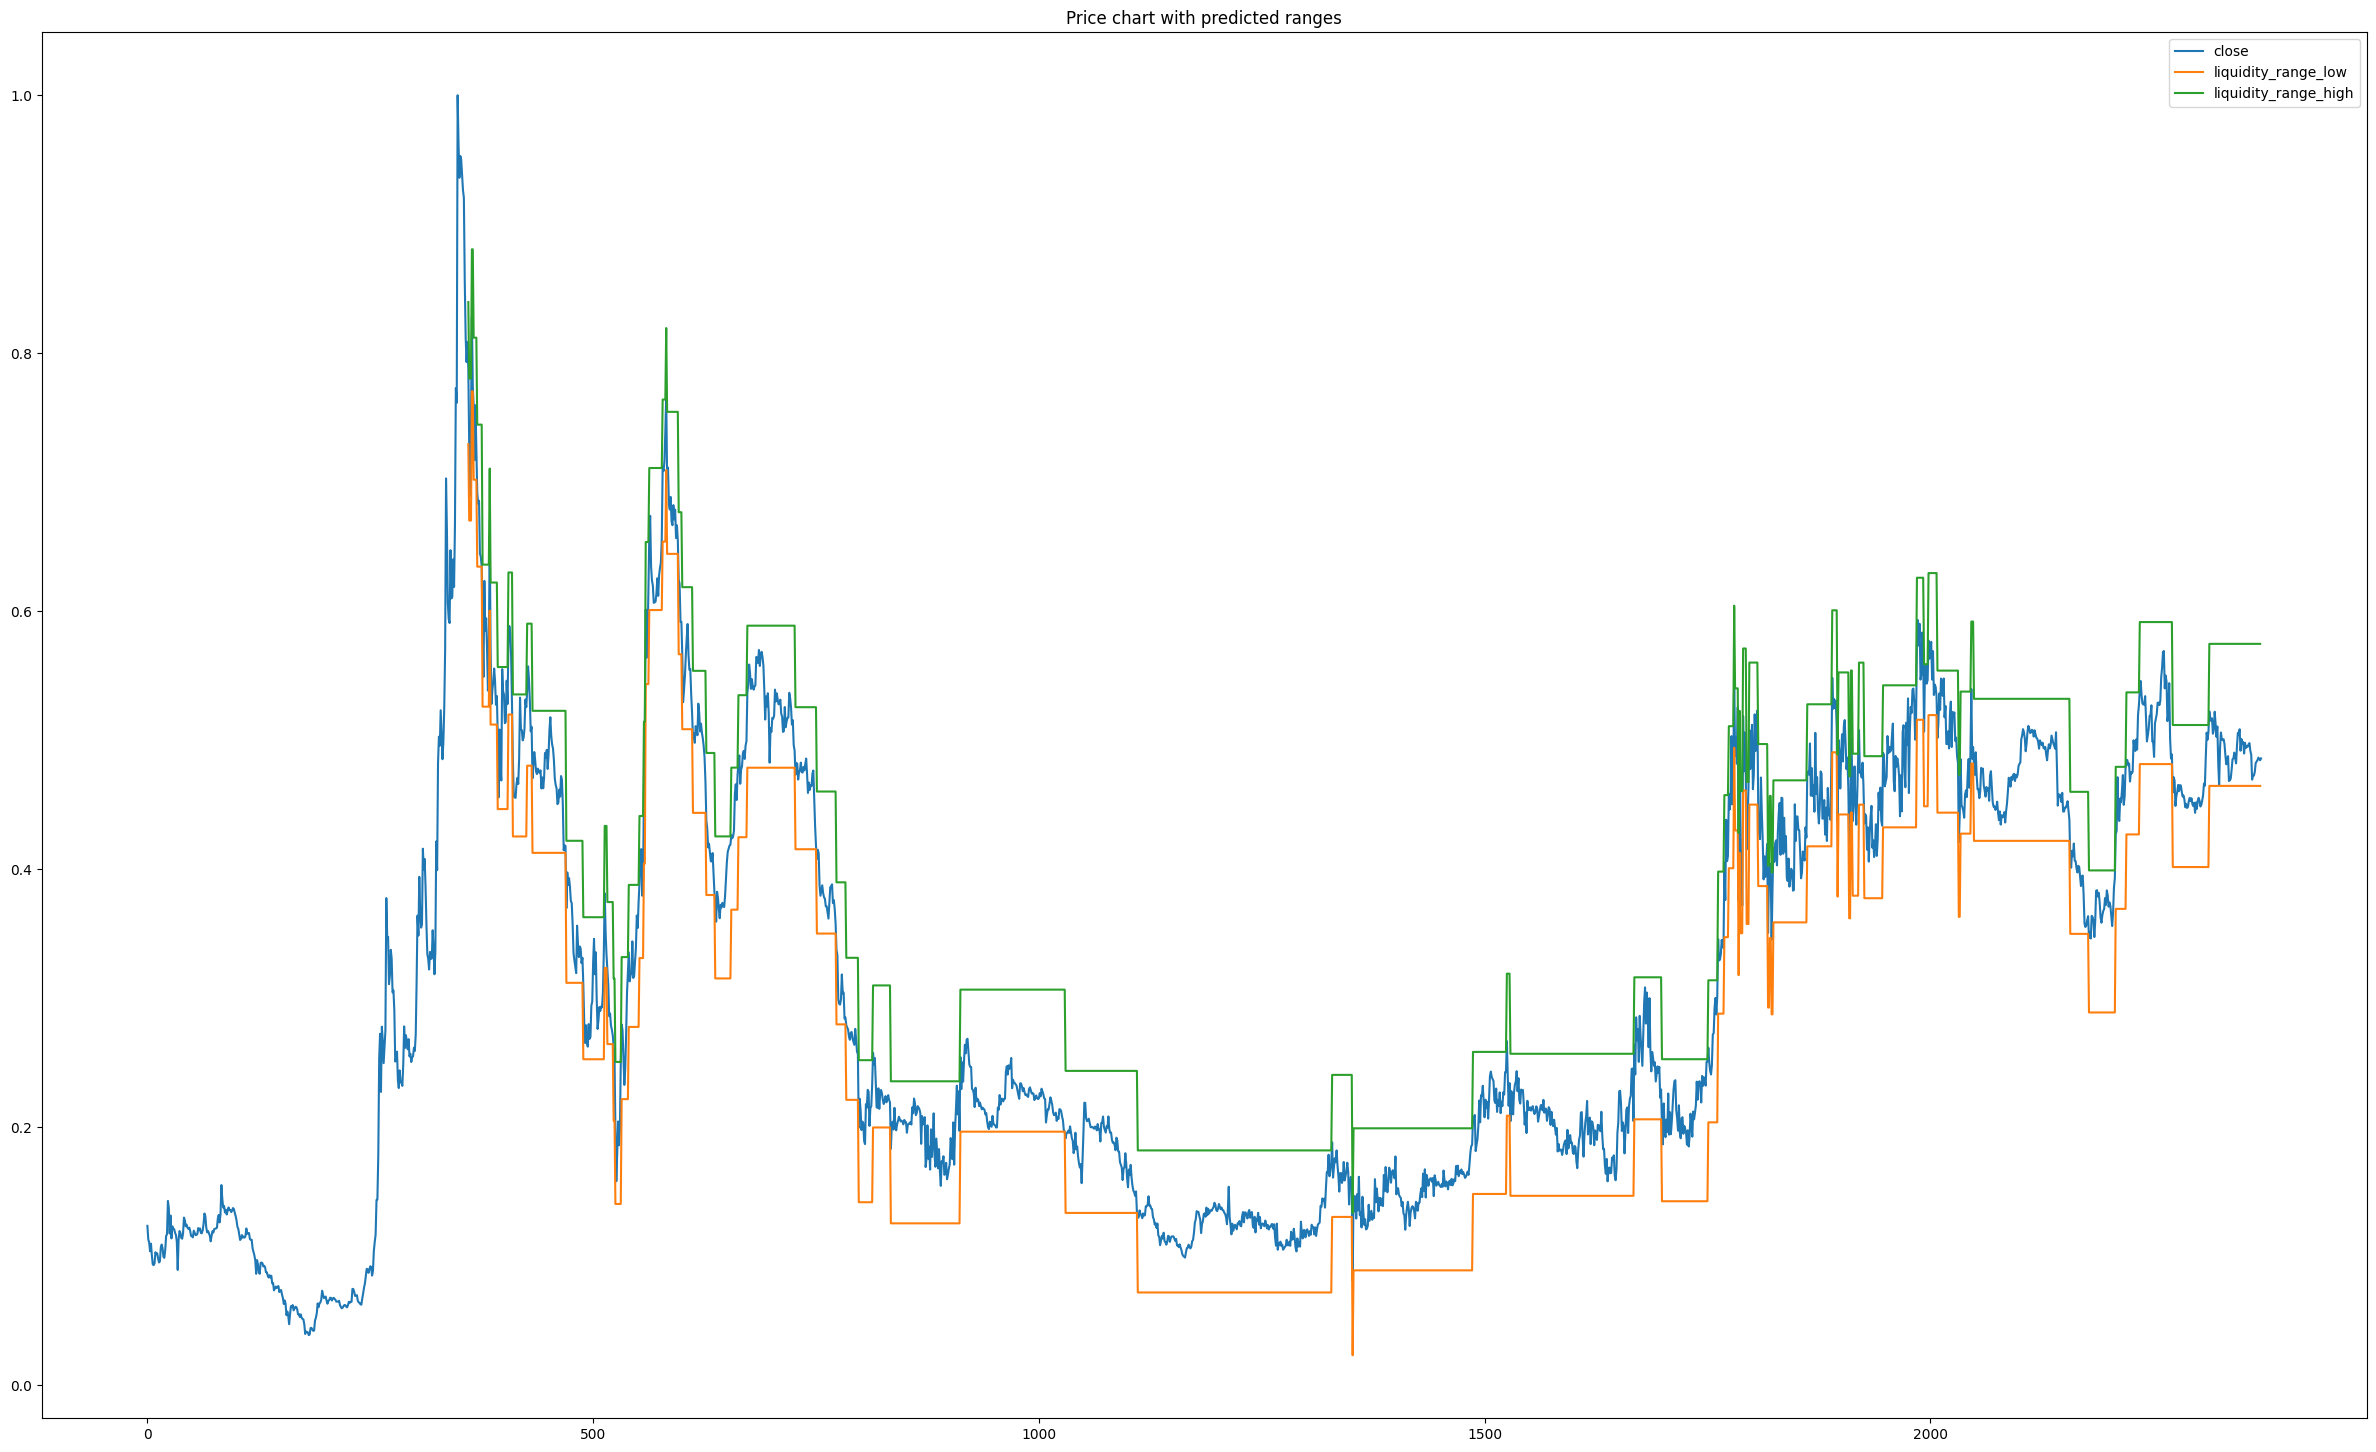

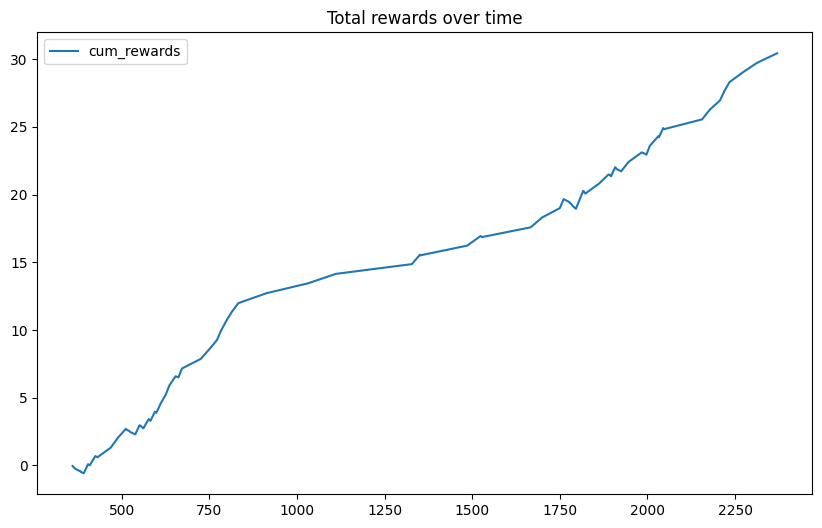

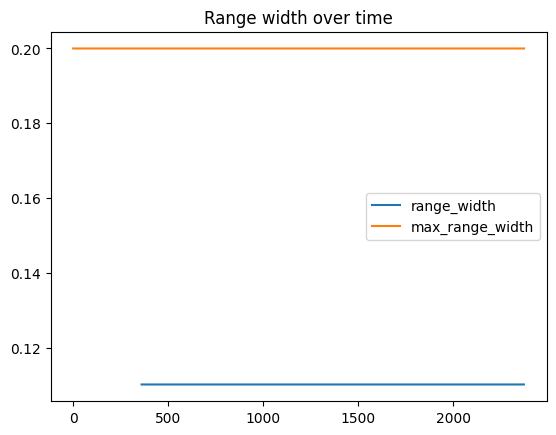

In [6]:
from importlib import reload 
from environment.backtest import backtest_model

total_rewards, range_changes, total_periods, avg_range_width = backtest_model(env, model)

Total range changes over 593 days: 8
Average liquidity lifespan: 74.125 days


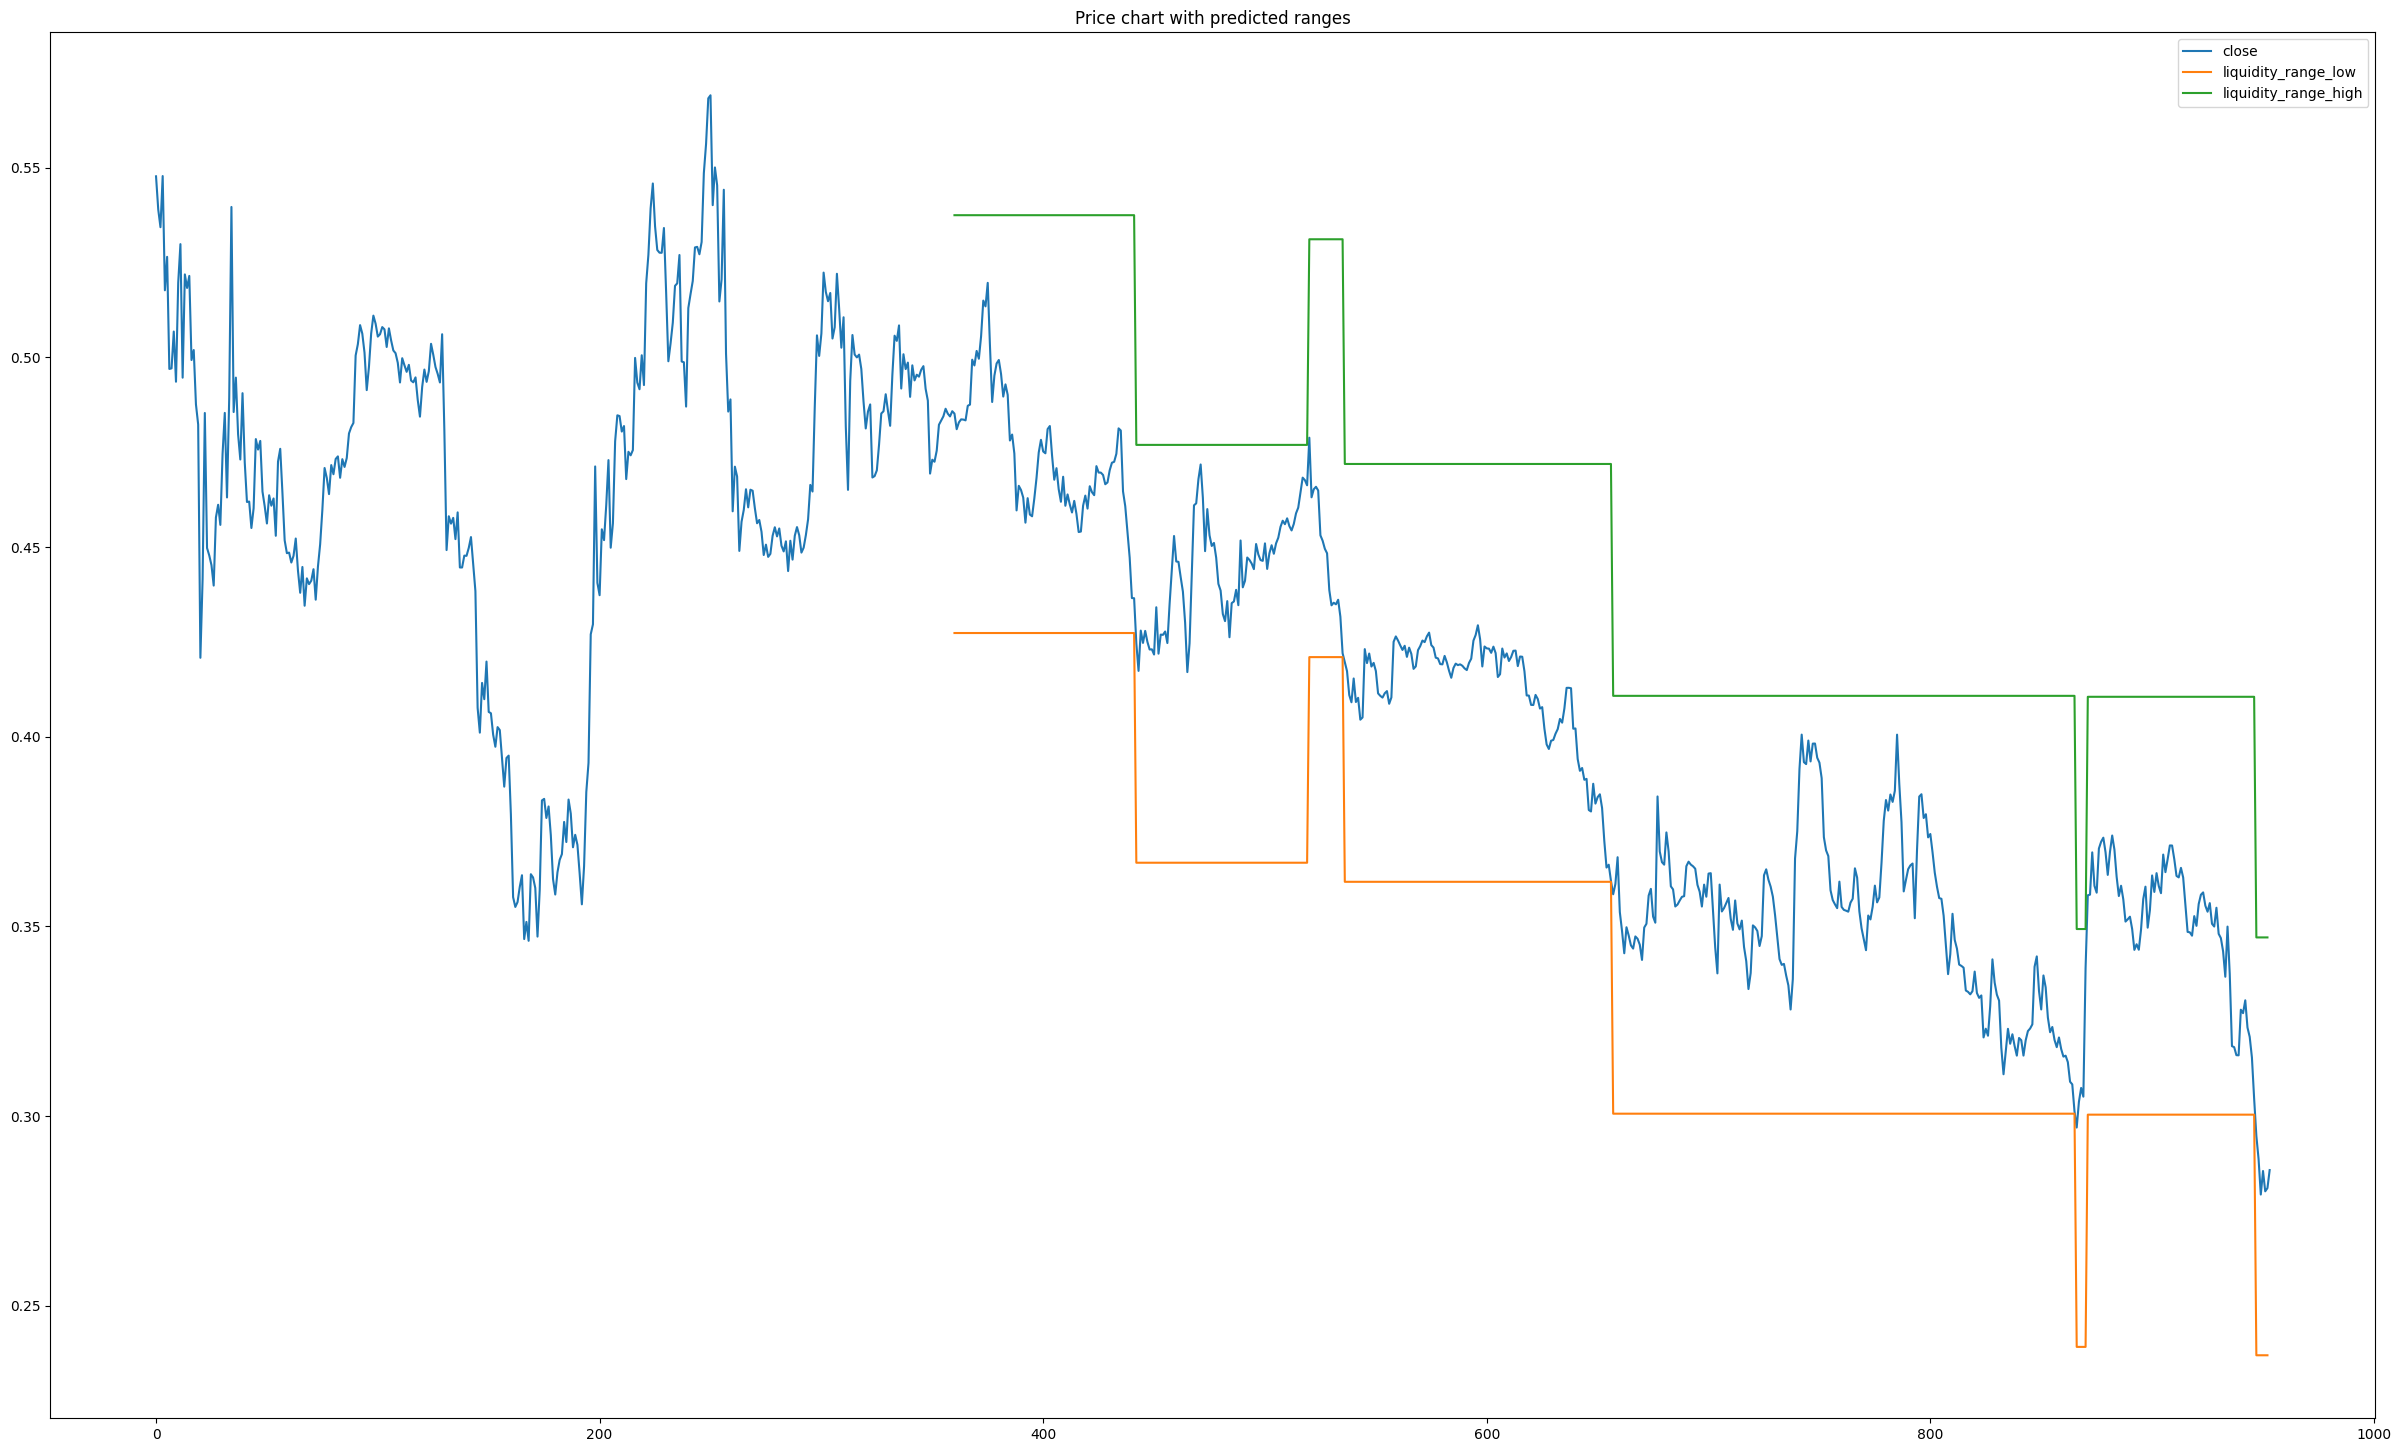

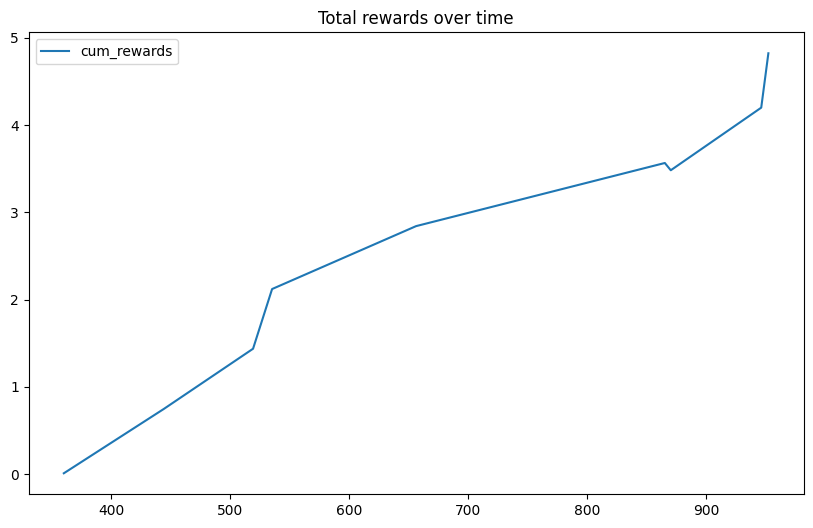

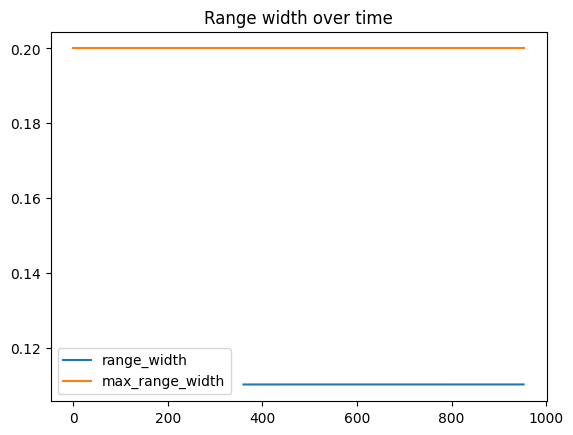

In [27]:
import matplotlib.pyplot as plt

test_env = UniswapV3Env(
    price_data=test_set, 
    lookback_periods=LOOKBACK_PERIODS,#24*15, #1 day
    penalties={
        'range_change': 0, 
        'range_error': .9,
        'range_too_wide': 0,
        'price_out_of_range': .1
    },
    max_range_width = MAX_RANGE_WIDTH,
    range_setting_relative = RELATIVE_RANGE_SETTING,
    cap_rewards=CAP_REWARDS,
    target_range_min_lifespan=TARGET_RANGE_MIN_LIFESPAN,
    min_lifespan_no_penalty=MIN_LIFESPAN_NO_PENALTY,
)

test_env._eval()
test_total_rewards, test_range_changes, test_total_periods, avg_range_width = backtest_model(test_env, model)

In [28]:
scaler.data_range_[0]

def get_price_from_scaled(scaled_price):
    return scaled_price * scaler.data_range_[0] + scaler.data_min_[0]

def get_current_liquidity_range(env):
    lower_bound = get_price_from_scaled(env.liquidity_range.lower_bound)
    upper_bound = get_price_from_scaled(env.liquidity_range.upper_bound)
    return lower_bound, upper_bound

lower_bound, upper_bound = get_current_liquidity_range(test_env)
print(f'current liquidity: {lower_bound:.4f}-{upper_bound:.4f}')

current liquidity: 0.0364-0.0524


## Looking for the optimal parameters
We perform grid-search on our environment parameters and evaluate the results both from a quantitative and qualitative point

In [ ]:
from stable_baselines3 import PPO, DQN, DDPG
from model.entropy_decay import EntropyDecayCallback
from stable_baselines3.common.noise import NormalActionNoise, OrnsteinUhlenbeckActionNoise
import uuid
import json
from environment.backtest import backtest_model

#Define the number of training steps
total_timesteps=2**17

callback = EntropyDecayCallback(initial_entropy_coef=0.1, final_entropy_coef=0.01, total_timesteps=total_timesteps)

#grid search params
params = {
    'max_range_width': [.15,.3, .45],
    'lookback_periods': [90, 180, 360],
    'target_range_min_lifespan': [10, 20, 30],
    'min_lifespan_no_penalty': [3, 7, 10]
}

training_set = df_train[:int(df_train.shape[0]*0.8)].copy()
#test_set = df_train[int(df_train.shape[0]*0.8)-LOOKBACK_PERIODS:].reset_index(drop=True).copy()

RELATIVE_RANGE_SETTING = False
CAP_REWARDS=True

datalog = []

for max_range_width in params['max_range_width']:
    for lookback_periods in params['lookback_periods']:
        for target_range_min_lifespan in params['target_range_min_lifespan']:
            for min_lifespan_no_penalty in params['min_lifespan_no_penalty']:
                simulation_id = str(uuid.uuid4())
                env = UniswapV3Env(
                    price_data=training_set, 
                    lookback_periods=lookback_periods,
                    penalties={
                        'range_change': 0, 
                        'range_error': .9,
                        'range_too_wide': 0,
                        'price_out_of_range': .1
                    },
                    max_range_width = max_range_width,
                    range_setting_relative=RELATIVE_RANGE_SETTING,
                    cap_rewards=CAP_REWARDS,
                    target_range_min_lifespan=target_range_min_lifespan,
                    min_lifespan_no_penalty=min_lifespan_no_penalty,
                )

                # Initialize the model
                model = PPO('MlpPolicy', env, verbose=1, ent_coef=0.01, learning_rate=0.001)

                # Train the model
                env._train()
                model.learn(total_timesteps=total_timesteps, callback=callback)
                
                #backtesting will print the charts for qualitative estimates
                total_rewards, total_ranges, total_periods, avg_range_width = backtest_model(env, model, chart_title=simulation_id)
                
                datalog.append({
                    'simulation_id': simulation_id,
                    'params': {
                        'max_range_width': float(max_range_width),
                        'lookback_periods': int(lookback_periods),
                        'target_range_min_lifespan': int(target_range_min_lifespan),
                        'min_lifespan_no_penalty': int(min_lifespan_no_penalty),   
                    },
                    'total_rewards': float(total_rewards),
                    'total_ranges': int(total_ranges),
                    'average_range_lifespan': float(total_ranges/total_periods)
                })
                
                with open('datalog_gridsearch.json', 'w') as f:
                    f.write(json.dumps(datalog))
                
                model.save(simulation_id)

## Quantitative evaluation

Since our reward function is very "virtual", we bring it a bit closer to reality by evaluating each of our models using a performance metric: we want our models to have the least amount of range changes for the smallest range widths possible. We derive a simple function:

$$performance = \frac{1}{changes^a * width^b}$$

The higher the score, the better.

In [50]:
def performance_metric(model, env, a=1, b=1):
    total_rewards, range_changes, total_periods, avg_range_width = backtest_model(env, model, show_plots=False, print_report=False)
    return 1 / (avg_range_width**a * range_changes**b)

kpi_data = []

for model_log in datalog:

    lookback_periods = model_log['params']['lookback_periods']
    max_range_width = model_log['params']['max_range_width']
    target_range_min_lifespan = model_log['params']['target_range_min_lifespan']
    min_lifespan_no_penalty = model_log['params']['min_lifespan_no_penalty']

    test_set = df_train[int(df_train.shape[0]*0.8)-lookback_periods:].reset_index(drop=True).copy()

    test_env = UniswapV3Env(
        price_data=test_set, 
        lookback_periods=lookback_periods,
        penalties={
            'range_change': 0, 
            'range_error': .9,
            'range_too_wide': 0,
            'price_out_of_range': .1
        },
        max_range_width = max_range_width,
        range_setting_relative = RELATIVE_RANGE_SETTING,
        cap_rewards=CAP_REWARDS,
        target_range_min_lifespan=target_range_min_lifespan,
        min_lifespan_no_penalty=min_lifespan_no_penalty,
    )

    model = PPO.load(model_log['simulation_id']+'.zip')
    
    #we place a higher importance on number of range changes, hence b=2
    kpi = performance_metric(model, test_env, b=2)
    kpi_data.append({'model_id': model_log['simulation_id'], 'performance_score': kpi})
    
df_test_results = pd.DataFrame(kpi_data).sort_values('performance_score', ascending=False).head(20)

for hyperparameters in ['lookback_periods', 'max_range_width', 'target_range_min_lifespan', 'min_lifespan_no_penalty',]:
    df_test_results[hyperparameters] = df_test_results.model_id.map({d['simulation_id']: d['params'][hyperparameters] for d in datalog})

df_test_results.head(5)

,model_id,performance_score,lookback_periods,max_range_width,target_range_min_lifespan,min_lifespan_no_penalty
46,546fd58a-5871-408d-a288-42ebb4000b48,0.994246,360,0.3,10,7
45,9dcde591-8d48-4df8-9b8c-9b1d2131365d,0.835726,360,0.3,10,3
53,4eb79222-3521-40d4-b203-e8c13c2f1702,0.833333,360,0.3,30,10
47,700db97d-a41c-40c0-a10c-00af8d6771ac,0.833333,360,0.3,10,10
48,bb4cd7b6-97b9-43d1-b120-e896ea91ac44,0.833333,360,0.3,20,3


## Qualitative model evaluation

We will retain the best model according to our simple performance_score: model ID `546fd58a-5871-408d-a288-42ebb4000b48`

Total range changes over 2011 days: 29
Average liquidity lifespan: 69.34482758620689 days
Total range changes over 593 days: 2
Average liquidity lifespan: 296.5 days


(0.7355058264776082, 2, 593, 0.2514469366300741)

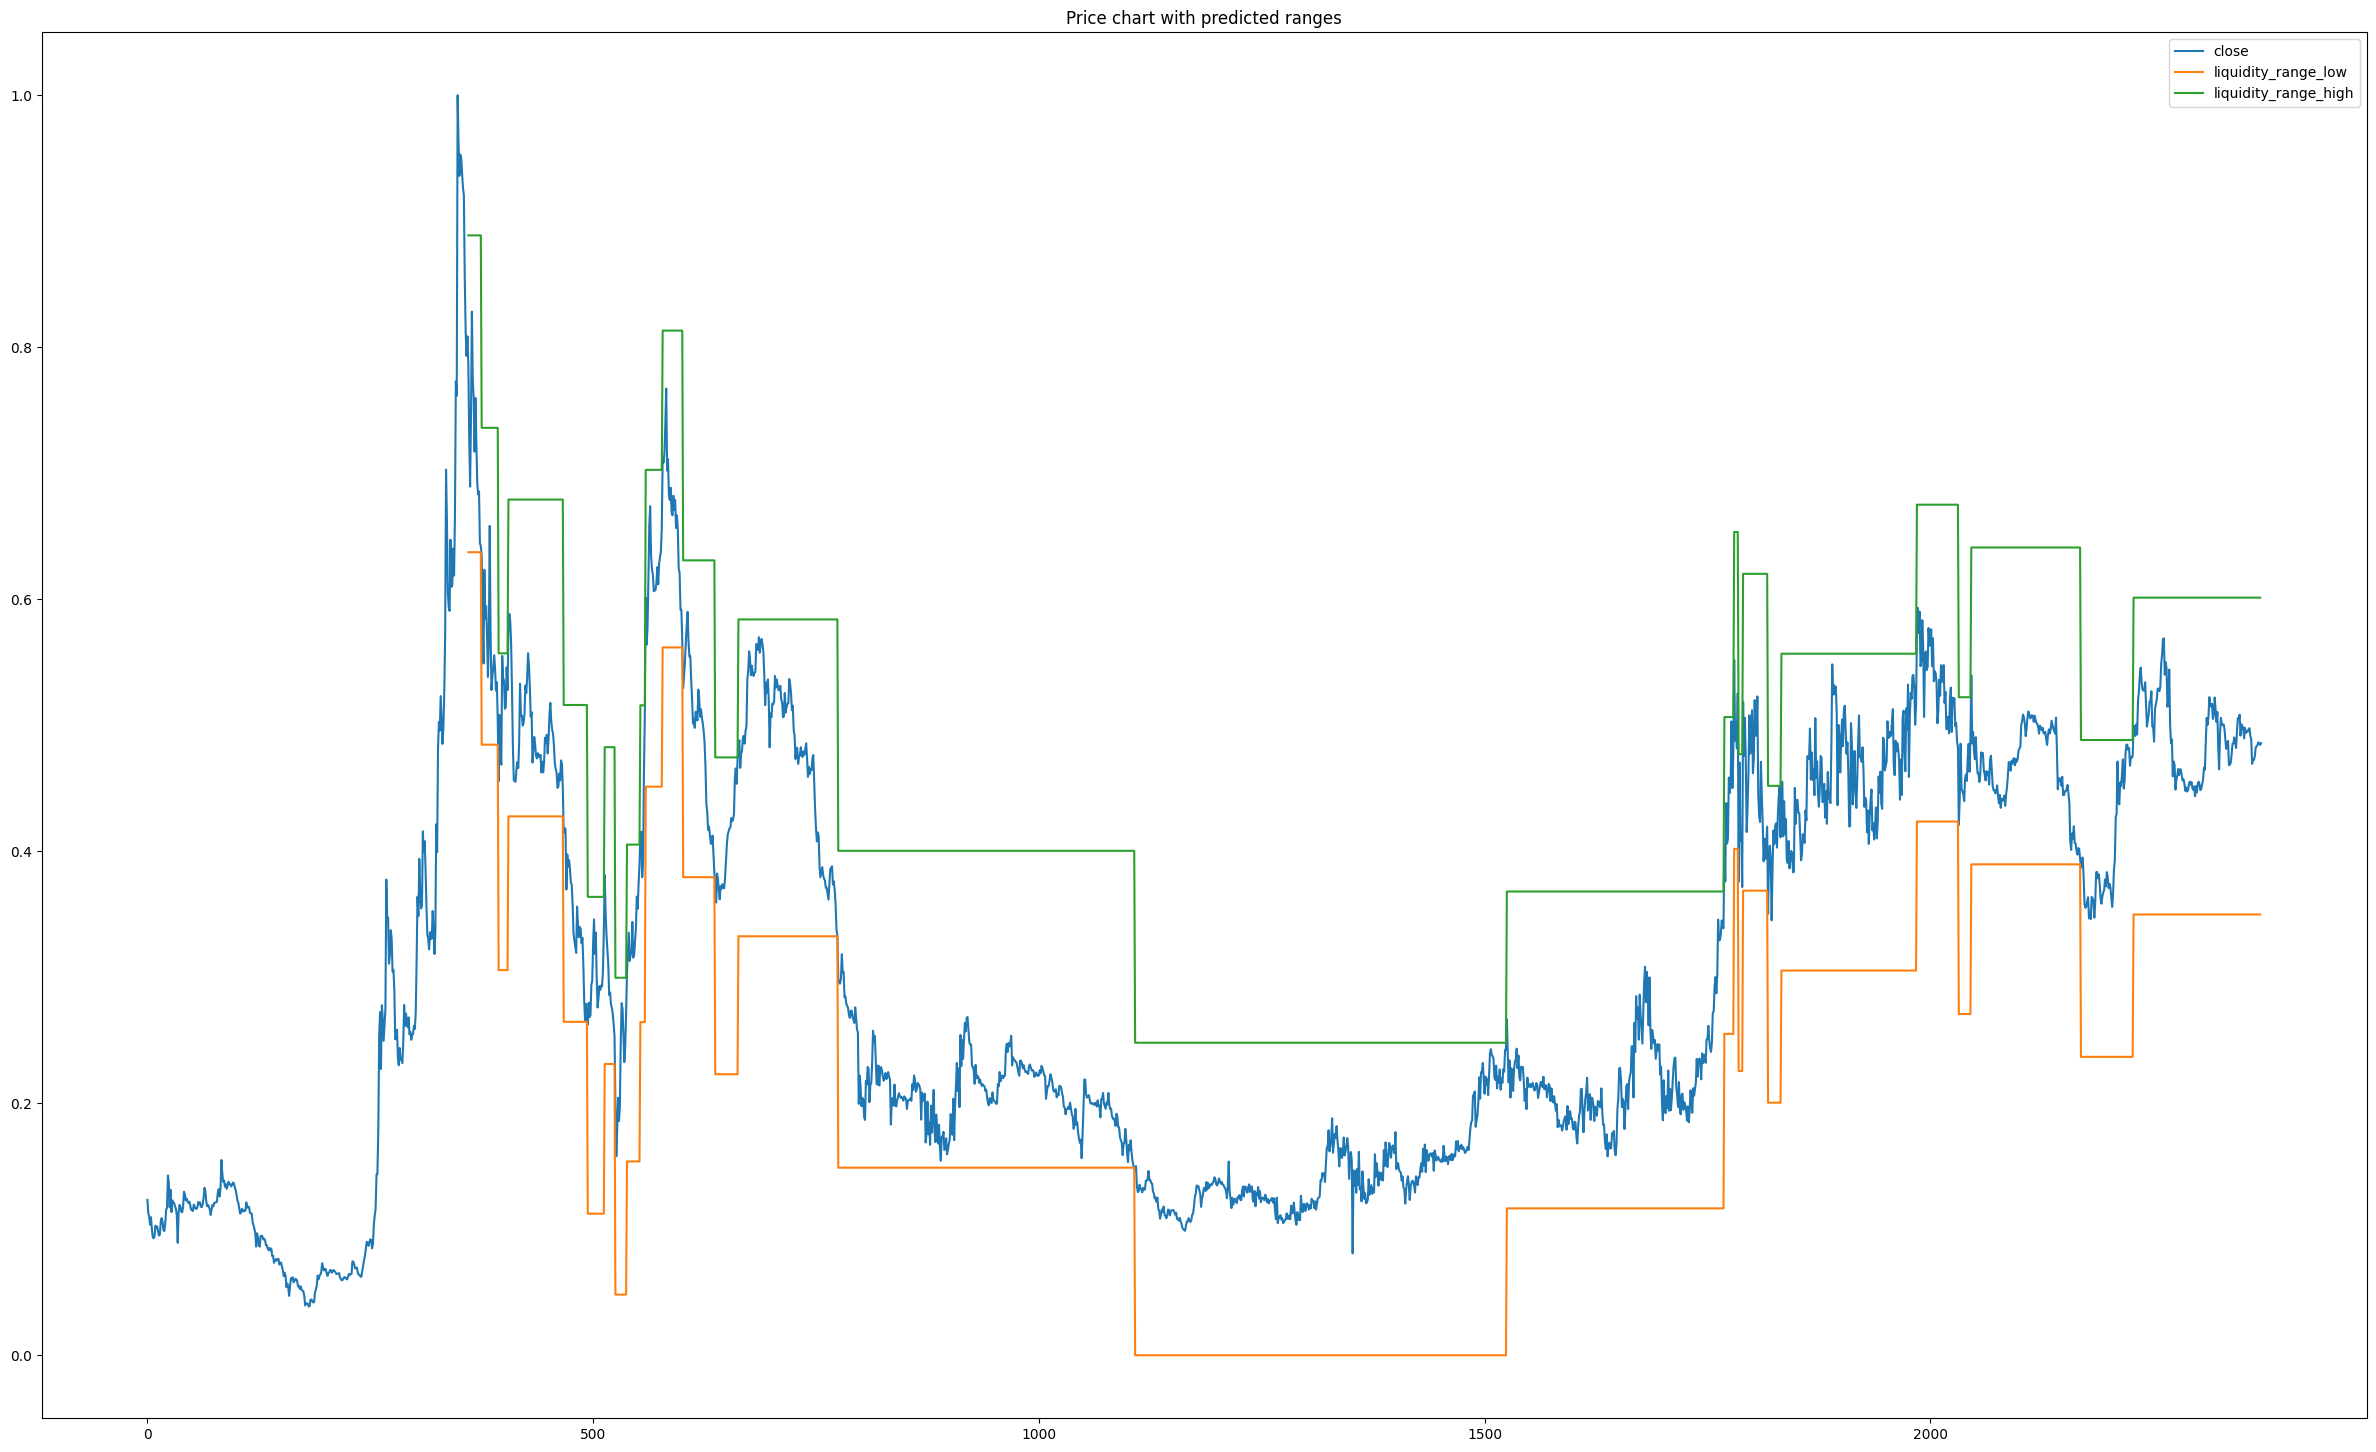

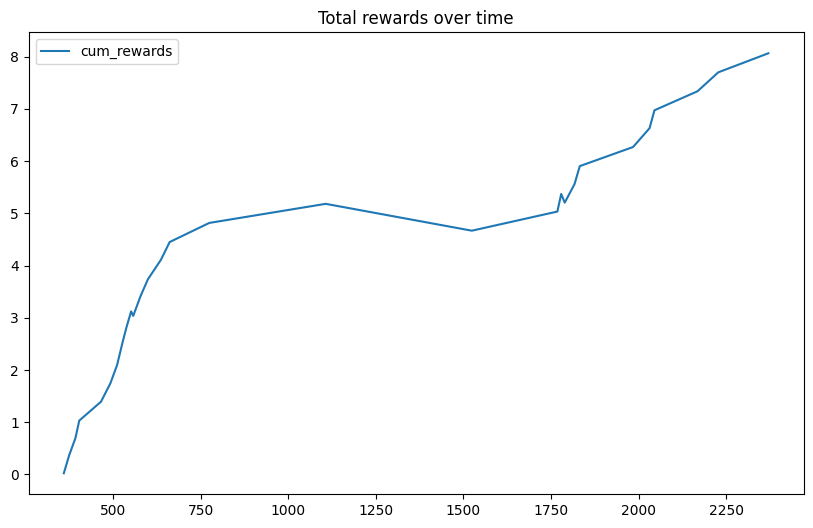

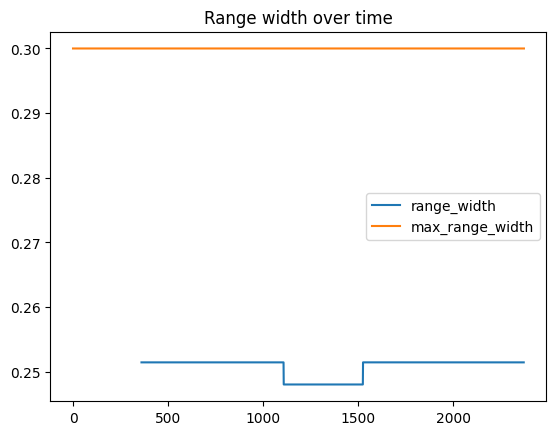

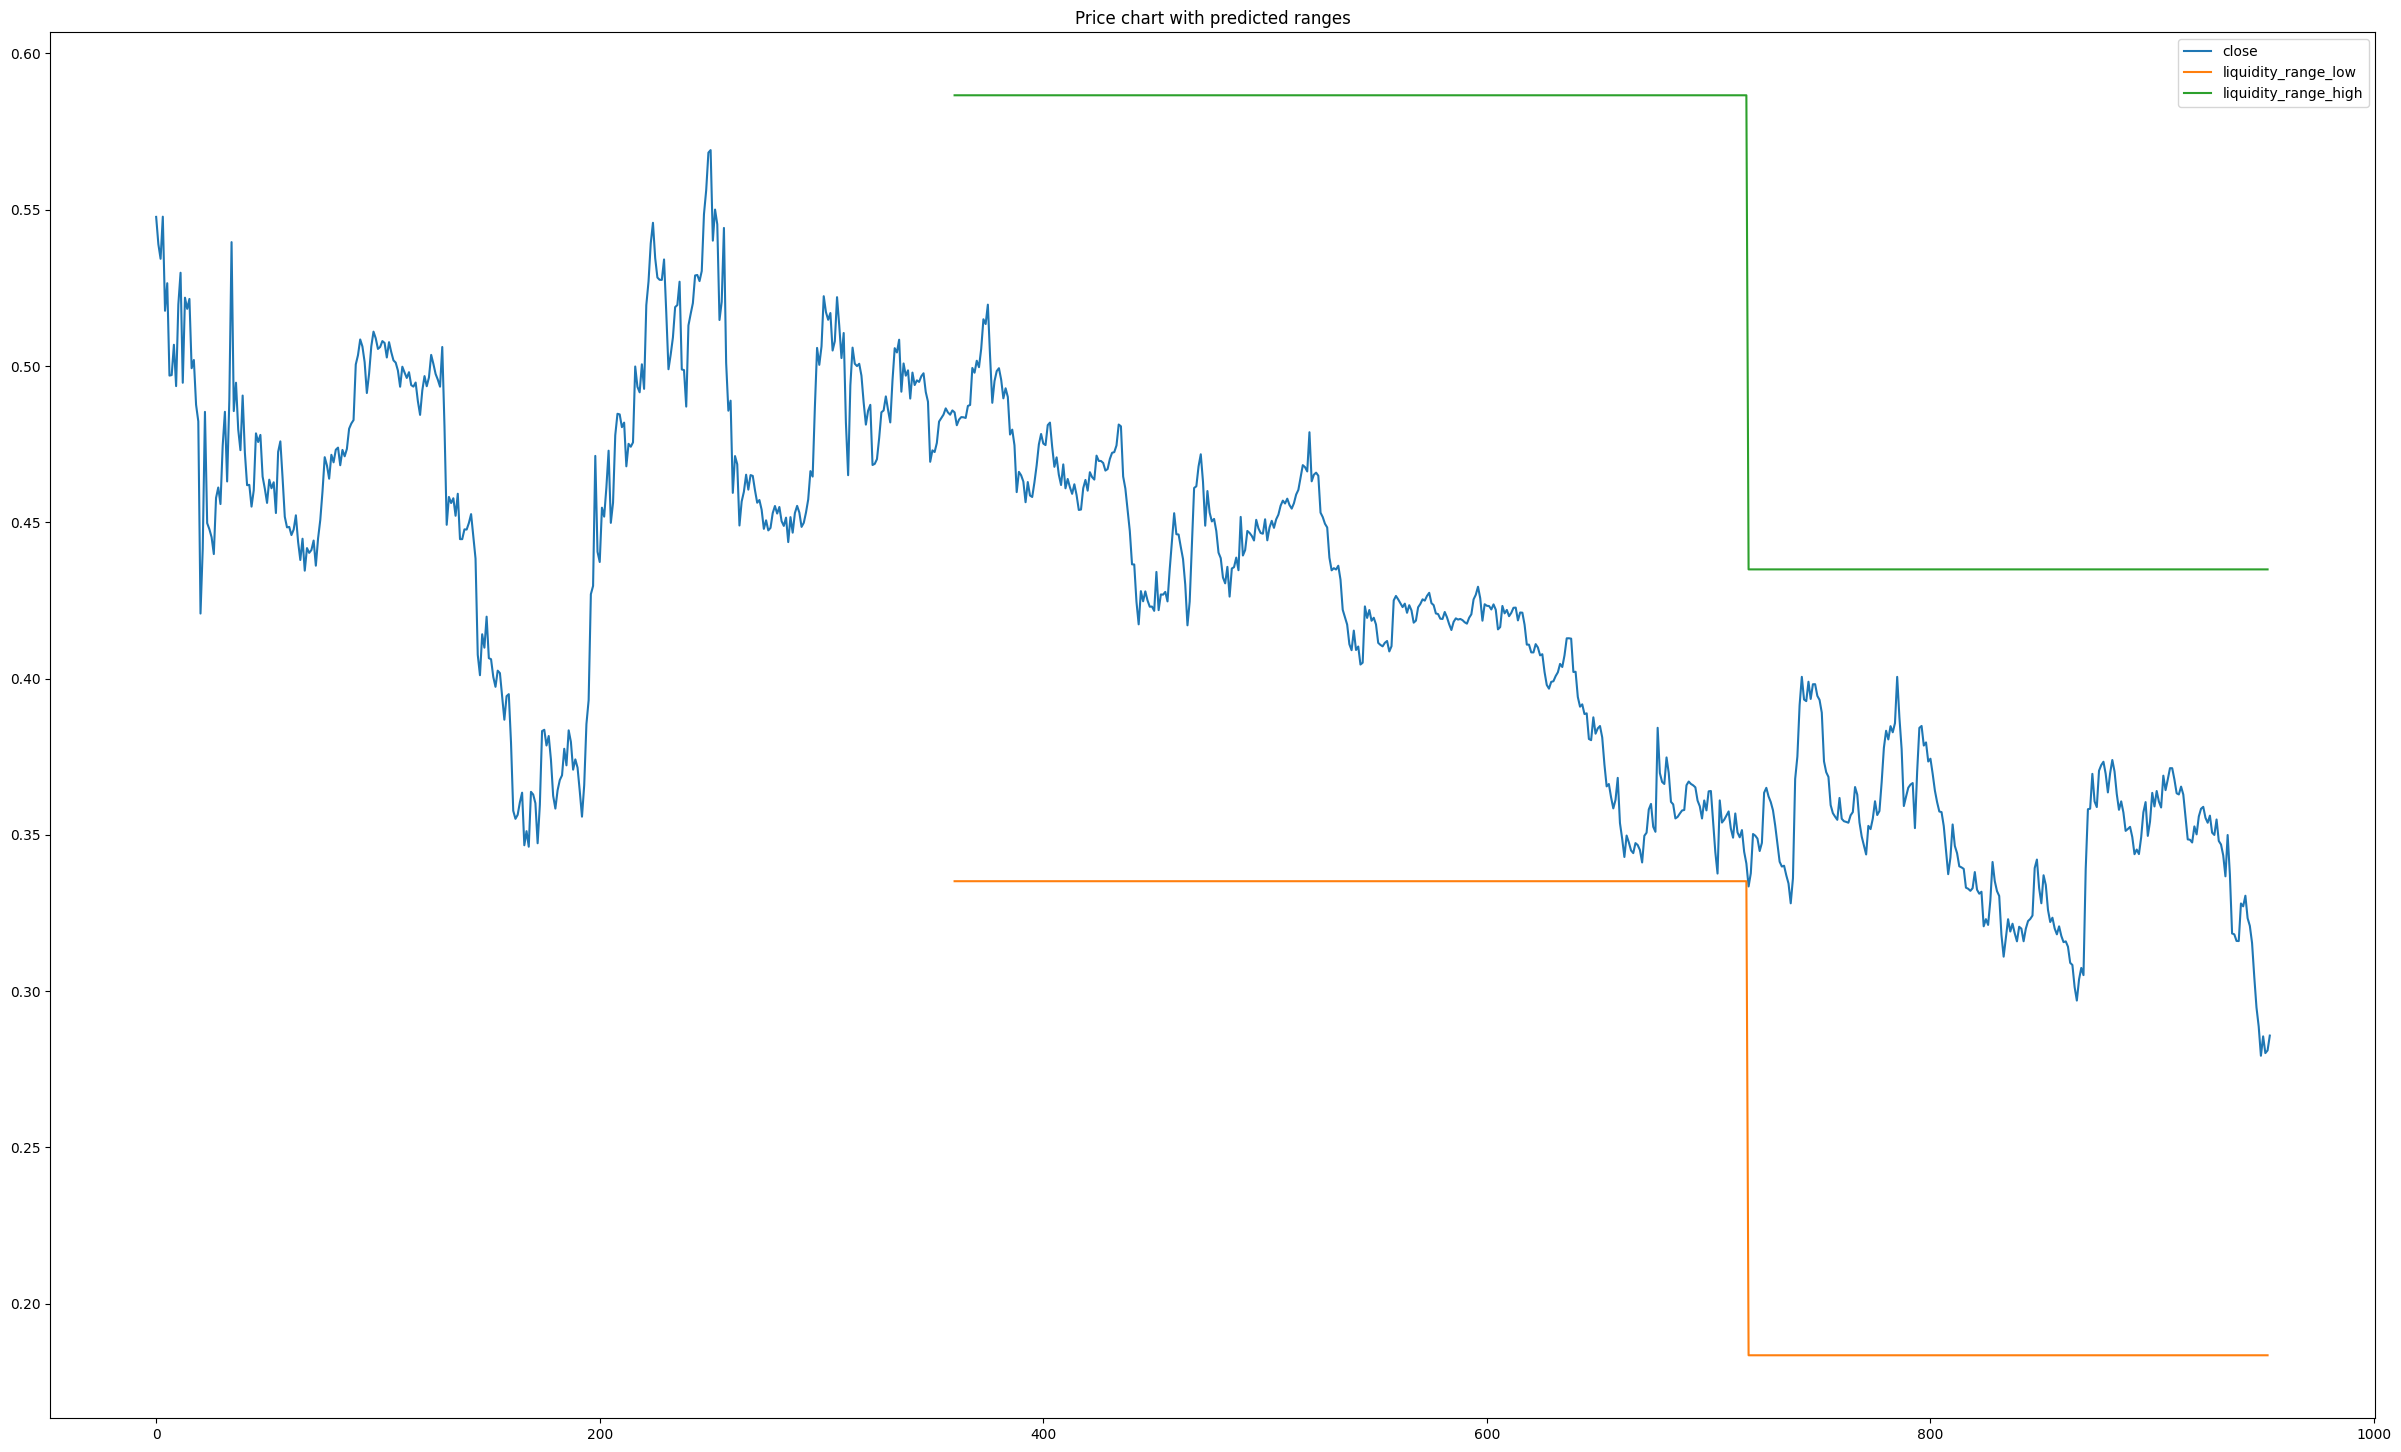

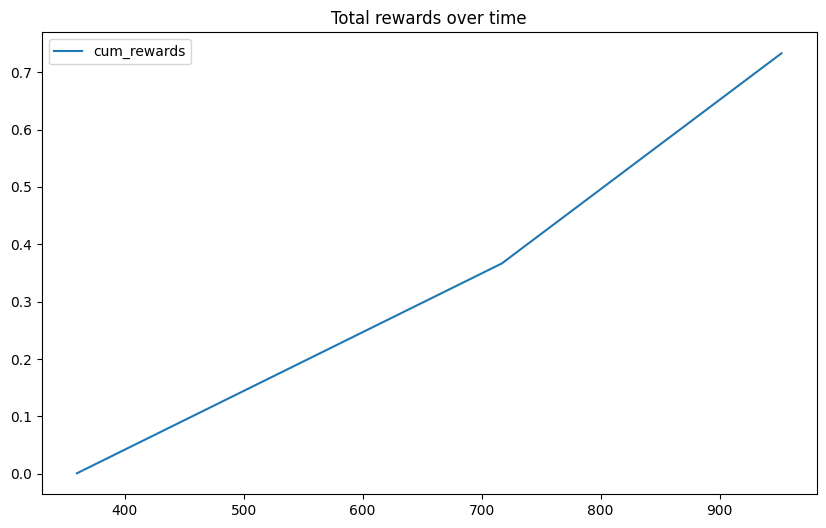

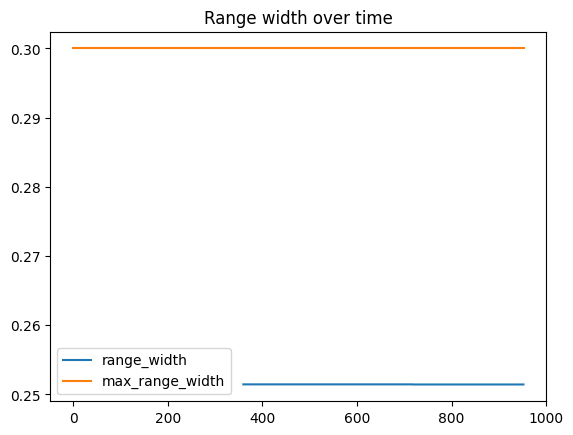

In [49]:
model_id = '546fd58a-5871-408d-a288-42ebb4000b48'
lookback_periods = 360
max_range_width = .3
target_range_min_lifespan = 10
min_lifespan_no_penalty = 7 

model = PPO.load(model_id + '.zip')

env = UniswapV3Env(
    price_data=training_set, 
    lookback_periods=lookback_periods,
    penalties={
        'range_change': 0, 
        'range_error': .9,
        'range_too_wide': 0,
        'price_out_of_range': .1
    },
    max_range_width = max_range_width,
    range_setting_relative=RELATIVE_RANGE_SETTING,
    cap_rewards=CAP_REWARDS,
    target_range_min_lifespan=target_range_min_lifespan,
    min_lifespan_no_penalty=min_lifespan_no_penalty,
)

test_env = UniswapV3Env(
        price_data=test_set, 
        lookback_periods=lookback_periods,
        penalties={
            'range_change': 0, 
            'range_error': .9,
            'range_too_wide': 0,
            'price_out_of_range': .1
        },
        max_range_width = max_range_width,
        range_setting_relative = RELATIVE_RANGE_SETTING,
        cap_rewards=CAP_REWARDS,
        target_range_min_lifespan=target_range_min_lifespan,
        min_lifespan_no_penalty=min_lifespan_no_penalty,
    )


backtest_model(env     , model, show_plots=True, print_report=True)
backtest_model(test_env, model, show_plots=True, print_report=True)
    